# Evaluate contrastive, supervised, and baseline models on Val/Test set

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.autonotebook import tqdm
import opensoundscape as opso

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# gill sans
plt.rcParams['font.family'] = 'Gill Sans'

import torch
def identity(x):
    return x

# local source code imports
import sys
sys.path.append(f'../../src/')
import evaluation
from evaluation import evaluate, make_pseudolabels, mean_range_table
from preprocessor import OvenbirdPreprocessor
import random
from model import Resnet18_Classifier, ContrastiveResnet18

palette = sns.color_palette("deep") + sns.color_palette("Dark2")

# set seed for reproducibility
random.seed(2024)
np.random.seed(2024)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_75418/3170153371.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## load individual-level song annotations for the Validation and Test sets
These are annotated Ovenbird songs to individual-level from acoustic localization arrays

In [3]:
labels_dir = "/Users/SML161/song25_oven_aiid/localization_dataset_labeled_clips"  # "/media/auk/projects/sml161/ecco46_loca_aiid/song25_oven_labeled_individuals/"
labels = pd.read_csv(f"{labels_dir}/labeled_clips.csv")

# prepare for prediction
labels["file"] = labels["rel_path"].apply(lambda x: Path(labels_dir) / x)
labels["song_center_time"] = 5  # we have 10s audio clip centered on the annotated song

val_labels = labels[labels["data_split"] == "val"]
test_labels = labels[labels["data_split"] == "test"]

## Generate or load test set embeddings with each model

In [4]:
# load the trained Ovenbird feature extractor model, using GPU device if one is available
ckpt_path = (
    "../../checkpoints/full_2025-04-10T11:02:36.028451_best.pth"  # full_best.pth"
)
# save_dir = "/media/auk/projects/sml161/ecco46_loca_aiid/train_pam/checkpoints"

device = (
    opso.ml.cnn._gpu_if_available()
)  # select MPS or CUDA GPU if available, otherwise CPU
ovenbird_feature_extractor = Resnet18_Classifier(num_classes=234)
ovenbird_feature_extractor.load_state_dict(torch.load(ckpt_path, map_location=device))
ovenbird_feature_extractor.device = device
ovenbird_feature_extractor.to(device)

# create standard preprocessor for Ovenbird song clips
pre = OvenbirdPreprocessor()
pre.pipeline.load_audio.set(load_metadata=False)

models = {
    "ovenbird": ovenbird_feature_extractor,
    "baseline_resnet18": ContrastiveResnet18(),
    "hawkears": None,  # HawkEars embeddings are created separately
    "birdnet": None,  # BirdNet embeddings are created separately
}

In [11]:
# unzip the HawkEars and BirdNet embeddings if precomputed_embeddings folder doesn't already exist
if not Path("../resources/precomputed_embeddings").exists():
    import zipfile

    with zipfile.ZipFile("../resources/precomputed_embeddings.zip", "r") as zip_ref:
        zip_ref.extractall("../resources/precomputed_embeddings")
    print("Unzipped precomputed embeddings.")

Unzipped precomputed embeddings.


In [10]:
test_set_embeddings_paths = {
    "ovenbird": "../resources/precomputed_embeddings/ovenbird_test_embeddings.npy",
    "baseline_resnet18": "../resources/precomputed_embeddings/baseline_resnet18_test_embeddings.npy",
    "hawkears": "../resources/precomputed_embeddings/hawkears_test_embeddings.npy",
    "birdnet": "../resources/precomputed_embeddings/birdnet_test_embeddings.npy",
}

In [49]:
# embed or load embeddings for validation and test sets with each model
test_set_embeddings = {}

for model_name, model in models.items():
    embedding_path = test_set_embeddings_paths[model_name]
    if Path(embedding_path).exists():
        print(f"loading saved {model_name} embeddings for test set")
        test_set_embeddings[model_name] = np.load(embedding_path)
    else:
        print(f"embedding test set samples with {model_name}")
        test_set_embeddings[model_name] = evaluation.embed(
            test_labels, model, pre, batch_size=128, num_workers=0
        )
        np.save(embedding_path, test_set_embeddings[model_name])

loading saved ovenbird embeddings for test set
loading saved baseline_resnet18 embeddings for test set
loading saved hawkears embeddings for test set
loading saved birdnet embeddings for test set


### Evaluate clustering performance using each feature set

Perform dimensionality and clustering and evaluate clustering metrics and accuracy


Will repeat this 30 times for each feature set since TSNE is stochastic

For accuracy, we use the optimal matching between predicted and labeled clusters via Hungarian Algorithm matching. Samples from redundant or missing clusters are treated as incorrect. 

In [ ]:
nreps = 30
performance_records = []
for i, (model, embeddings) in enumerate(test_set_embeddings.items()):
    print(f"Clustering {model} embeddings")

    for i in tqdm(range(nreps)):
        labels, features = evaluation.cluster(
            test_labels,
            embeddings,
            min_cluster_size=7,
            reduced_n_dimensions=3,
            reduction_algorithm="tsne",
        )

        performance = evaluate(test_labels["aiid_label"].values, labels)
        performance["model"] = model
        performance_records.append(performance)
performance_df = pd.DataFrame(performance_records)
performance_df.to_csv("../../results/test_set_performance.csv", index=False)

Clustering ovenbird embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering baseline_resnet18 embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering hawkears embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering birdnet embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

plot metrics for each model

In [ ]:
metrics_list = ["accuracy", "ari", "nmi", "fmi", "v_measure"]
summary = mean_range_table(performance_df, "model", metrics_list).sort_values(
    by="accuracy", ascending=False
)
summary.to_csv("../../results/test_set_performance_summary.csv", index=False)
summary

,accuracy,ari,nmi,fmi,v_measure
model,,,,,
ovenbird,0.99 (0.99-0.99),0.98 (0.98-0.99),0.99 (0.98-0.99),0.99 (0.98-0.99),0.99 (0.98-0.99)
baseline_resnet18,0.38 (0.24-0.41),0.14 (0.02-0.17),0.38 (0.11-0.43),0.43 (0.36-0.44),0.38 (0.11-0.43)
birdnet,0.26 (0.21-0.52),0.05 (0.00-0.30),0.15 (0.03-0.56),0.34 (0.27-0.42),0.15 (0.03-0.56)
hawkears,0.22 (0.20-0.26),0.01 (-0.00-0.02),0.06 (0.02-0.22),0.28 (0.23-0.33),0.06 (0.02-0.22)


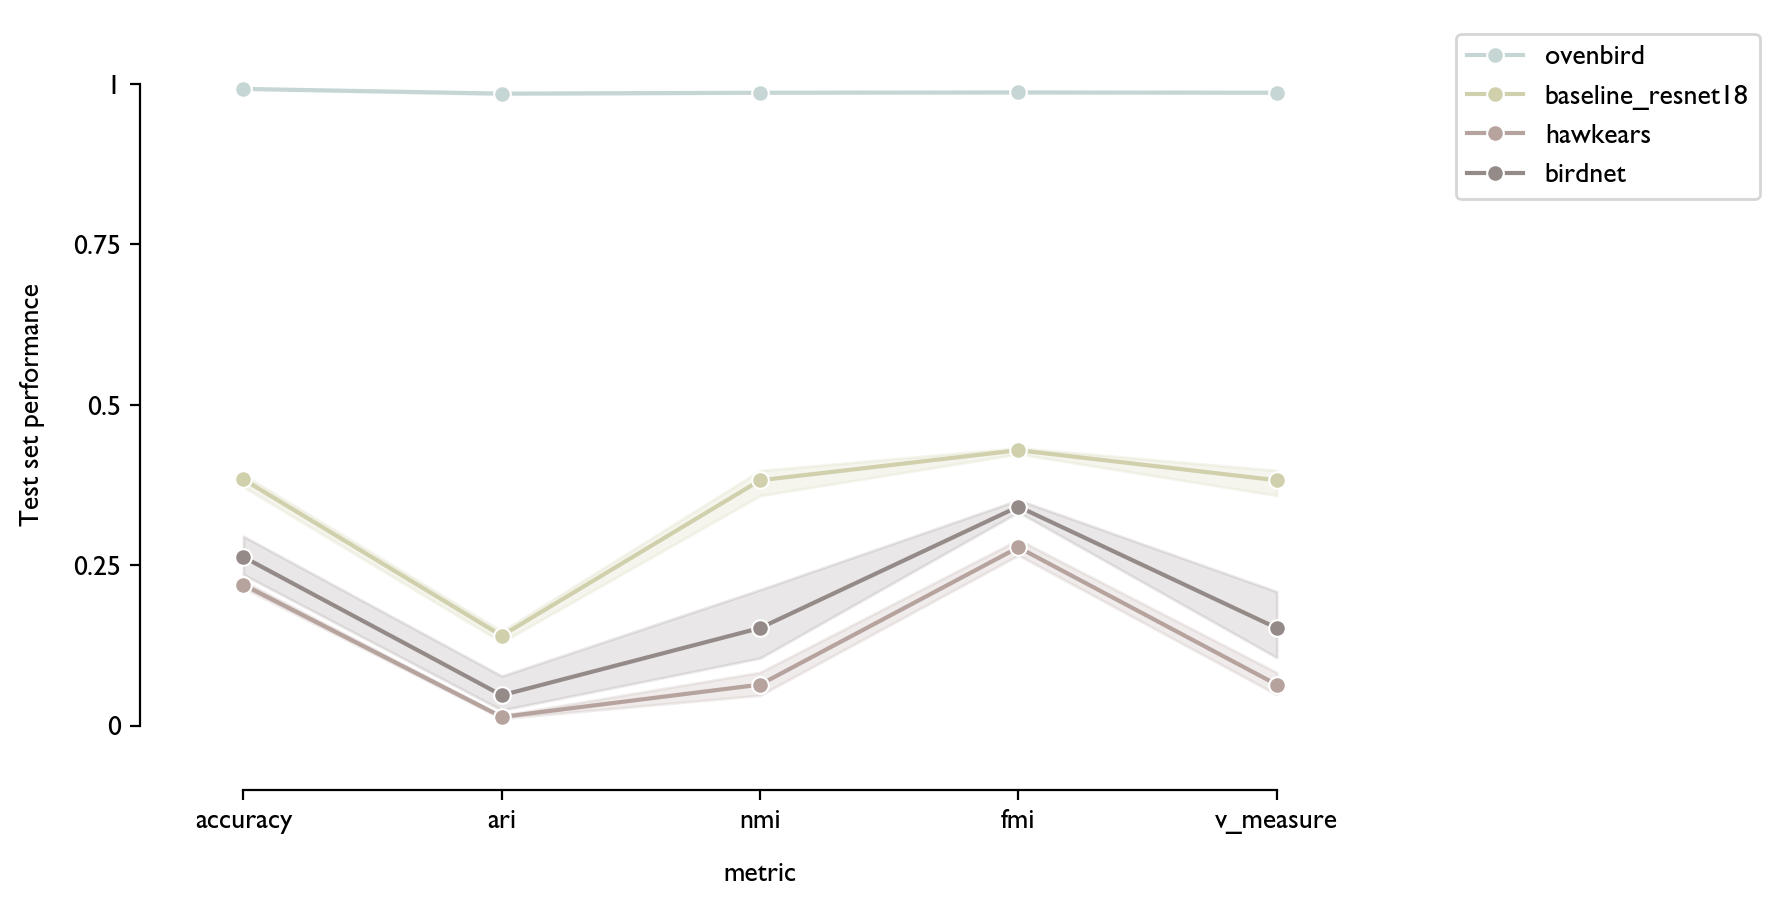

In [ ]:
import seaborn as sns

# sns.set_palette(sns.color_palette("crest")+sns.color_palette("flare",8))
# https://coolors.co/dde0bd-d0d1ac-b6a39e-948b89-726e75
# define palette of custom colors:
sns.set_palette(["#C6D6D5", "#D0D1AC", "#B6A39E", "#948B89", "#726E75"])
figsize(8, 5)

fig, ax = plt.subplots()

performance_long = (
    performance_df.set_index("model")[metrics_list].stack().to_frame().reset_index()
)
performance_long.columns = ["model", "metric", "value"]
sns.lineplot(
    performance_long,
    x="metric",
    y="value",
    hue="model",
    marker="o",
    ax=ax,
    errorbar=("ci", 95),
)

# metrics = pd.DataFrame(performance_df).loc[['accuracy','ari','nmi','fmi','v_measure']].T.sort_values(by='accuracy',ascending=False)#.round(2)

# # summary = r.groupby(['strategy','Name'])[metrics].mean().sort_values('accuracy', ascending=False)
# # summary=summary.dropna().round(2)
# # summary=summary.rename(columns={'ari (Max)':'ARI','nmi':'NMI','accuracy':'Accuracy','fmi':'FMI','v_measure':'V Measure'})
# sns.lineplot(data=performance_df.set_index('model').stack(),)
# ax.plot(metrics.T,marker='o')
import tuftelike

tuftelike.adjust(metrics_list, [0, 1], ax=ax)

# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.ylabel("Test set performance")
plt.savefig("../../figures/Figure4d_test_set_performance.pdf")

# repeat for validation set

In [ ]:
validation_set_embeddings_paths = {
    "ovenbird": "../resources/precomputed_embeddings/ovenbird_val_embeddings.npy",
    "baseline_resnet18": "../resources/precomputed_embeddings/baseline_resnet18_val_embeddings.npy",
    "hawkears": "../resources/precomputed_embeddings/hawkears_val_embeddings.npy",
    "birdnet": "../resources/precomputed_embeddings/birdnet_val_embeddings.npy",
}

In [ ]:
# embed or load embeddings for validation and test sets with each model
validation_set_embeddings = {}

for model_name, model in models.items():
    embedding_path = validation_set_embeddings_paths[model_name]
    if Path(embedding_path).exists():
        print(f"loading saved {model_name} embeddings for validation set")
        validation_set_embeddings[model_name] = np.load(embedding_path)
    else:
        print(f"embedding valiation set samples with {model_name}")
        validation_set_embeddings[model_name] = evaluation.embed(
            val_labels, model, pre, batch_size=128, num_workers=0
        )
        np.save(embedding_path, validation_set_embeddings[model_name])

loading saved ovenbird embeddings for test set
loading saved baseline_resnet18 embeddings for test set
loading saved hawkears embeddings for test set
loading saved birdnet embeddings for test set


### Evaluate clustering performance using each feature set

Perform dimensionality and clustering and evaluate clustering metrics and accuracy


Will repeat this 30 times for each feature set since TSNE is stochastic

For accuracy, we use the optimal matching between predicted and labeled clusters via Hungarian Algorithm matching. Samples from redundant or missing clusters are treated as incorrect. 

In [ ]:
nreps = 30
performance_records = []
for i, (model, embeddings) in enumerate(validation_set_embeddings.items()):
    print(f"Clustering {model} embeddings")

    for i in tqdm(range(nreps)):
        labels, features = evaluation.cluster(
            val_labels,
            embeddings,
            min_cluster_size=7,
            reduced_n_dimensions=3,
            reduction_algorithm="tsne",
        )

        performance = evaluate(val_labels["aiid_label"].values, labels)
        performance["model"] = model
        performance_records.append(performance)
performance_df = pd.DataFrame(performance_records)
performance_df.to_csv("../results/validation_set_performance.csv", index=False)

Clustering ovenbird embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering baseline_resnet18 embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering hawkears embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

Clustering birdnet embeddings


  0%|          | 0/30 [00:00<?, ?it/s]

plot metrics for each model

In [ ]:
metrics_list = ["accuracy", "ari", "nmi", "fmi", "v_measure"]
summary = mean_range_table(performance_df, "model", metrics_list).sort_values(
    by="accuracy", ascending=False
)
summary.to_csv("../../results/validation_set_performance_summary.csv", index=False)
summary

,accuracy,ari,nmi,fmi,v_measure
model,,,,,
ovenbird,0.93 (0.92-0.94),0.95 (0.94-0.95),0.97 (0.96-0.97),0.95 (0.95-0.96),0.97 (0.96-0.97)
birdnet,0.49 (0.11-0.53),0.21 (0.00-0.28),0.60 (0.02-0.64),0.30 (0.24-0.35),0.60 (0.02-0.64)
baseline_resnet18,0.13 (0.13-0.13),0.01 (0.00-0.01),0.08 (0.06-0.08),0.24 (0.24-0.24),0.08 (0.06-0.08)
hawkears,0.13 (0.10-0.21),0.01 (0.00-0.03),0.07 (0.01-0.29),0.22 (0.15-0.24),0.07 (0.01-0.29)


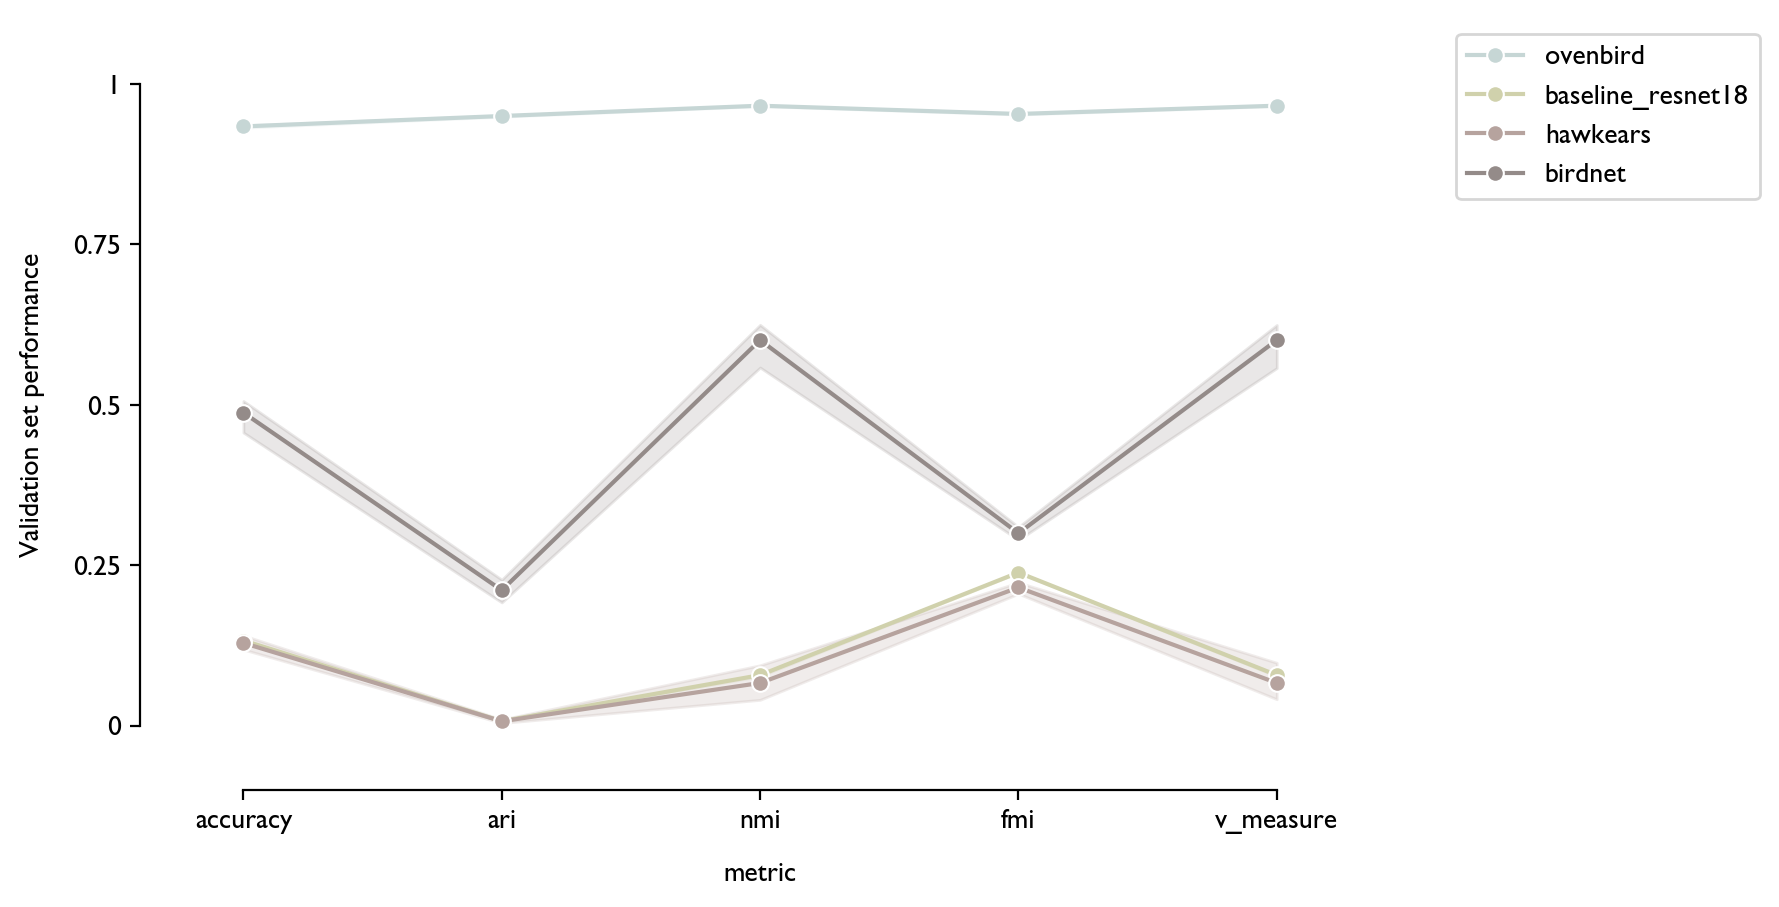

In [ ]:
import seaborn as sns

# sns.set_palette(sns.color_palette("crest")+sns.color_palette("flare",8))
# https://coolors.co/dde0bd-d0d1ac-b6a39e-948b89-726e75
# define palette of custom colors:
sns.set_palette(["#C6D6D5", "#D0D1AC", "#B6A39E", "#948B89", "#726E75"])
figsize(8, 5)

fig, ax = plt.subplots()

performance_long = (
    performance_df.set_index("model")[metrics_list].stack().to_frame().reset_index()
)
performance_long.columns = ["model", "metric", "value"]
sns.lineplot(
    performance_long,
    x="metric",
    y="value",
    hue="model",
    marker="o",
    ax=ax,
    errorbar=("ci", 95),
)

# metrics = pd.DataFrame(performance_df).loc[['accuracy','ari','nmi','fmi','v_measure']].T.sort_values(by='accuracy',ascending=False)#.round(2)

# # summary = r.groupby(['strategy','Name'])[metrics].mean().sort_values('accuracy', ascending=False)
# # summary=summary.dropna().round(2)
# # summary=summary.rename(columns={'ari (Max)':'ARI','nmi':'NMI','accuracy':'Accuracy','fmi':'FMI','v_measure':'V Measure'})
# sns.lineplot(data=performance_df.set_index('model').stack(),)
# ax.plot(metrics.T,marker='o')
import tuftelike

tuftelike.adjust(metrics_list, [0, 1], ax=ax)

# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.ylabel("Validation set performance")
plt.savefig("../../results/validation_set_performance.pdf")

# Create labels and add to table

In [ ]:
all_labels = pd.concat([val_labels, test_labels])
for i, (model, test_emb) in enumerate(test_set_embeddings.items()):
    val_emb = validation_set_embeddings[model]
    all_embeddings = np.concatenate([val_emb, test_emb], axis=0)

    print(f"Clustering {model} embeddings")

    model_labels, features = evaluation.cluster(
        all_labels,
        all_embeddings,
        min_cluster_size=7,
        reduced_n_dimensions=3,
        reduction_algorithm="tsne",
        cluster_grouping_col="data_split",
    )
    all_labels[f"{model}_cluster_labels"] = model_labels
# all_labels.to_csv("../../results/all_labels_with_clusters.csv", index=False)

Clustering ovenbird embeddings
clustering each value of data_split separately


  0%|          | 0/2 [00:00<?, ?it/s]

Clustering baseline_resnet18 embeddings
clustering each value of data_split separately


  0%|          | 0/2 [00:00<?, ?it/s]

Clustering hawkears embeddings
clustering each value of data_split separately


  0%|          | 0/2 [00:00<?, ?it/s]

Clustering birdnet embeddings
clustering each value of data_split separately


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
evaluate(all_labels["aiid_label"].values, all_labels["ovenbird_cluster_labels"].values)

{'ari': 0.9536698389314858,
 'nmi': 0.9735863596466825,
 'fmi': 0.9558536097064886,
 'homogeneity': 0.9661741698376615,
 'completeness': 0.9811131567490868,
 'v_measure': 0.9735863596466825,
 'purity': 0.9621498864496594,
 'accuracy': 0.9525611910169064}

In [ ]:
evaluate(
    all_labels["aiid_label"].values,
    all_labels["baseline_resnet18_cluster_labels"].values,
)

{'ari': 0.07376073640949152,
 'nmi': 0.3948894073900262,
 'fmi': 0.2693415055902419,
 'homogeneity': 0.25427792444905156,
 'completeness': 0.8833887783046044,
 'v_measure': 0.3948894073900262,
 'purity': 0.20893262679788038,
 'accuracy': 0.20893262679788038}

In [ ]:
evaluate(all_labels["aiid_label"].values, all_labels["hawkears_cluster_labels"].values)

{'ari': 0.05190318363831792,
 'nmi': 0.29420556657935715,
 'fmi': 0.22239610639893181,
 'homogeneity': 0.194525271782482,
 'completeness': 0.6034101079222525,
 'v_measure': 0.2942055665793572,
 'purity': 0.1461014383043149,
 'accuracy': 0.1455967701236437}

In [ ]:
evaluate(all_labels["aiid_label"].values, all_labels["birdnet_cluster_labels"].values)

{'ari': 0.20583910642181852,
 'nmi': 0.6202409428189083,
 'fmi': 0.3074677759310544,
 'homogeneity': 0.5585023491565806,
 'completeness': 0.6973254787133122,
 'v_measure': 0.6202409428189084,
 'purity': 0.4996214988644966,
 'accuracy': 0.40423921271763813}